<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

# Group Number:37
# Student 1: Jiong Li | 1533312
# Student 2: Peter Elmers | 1734350
# Student 3: P.T.C.M. Tholhuijsen | 1237447

In [1]:
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [3]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


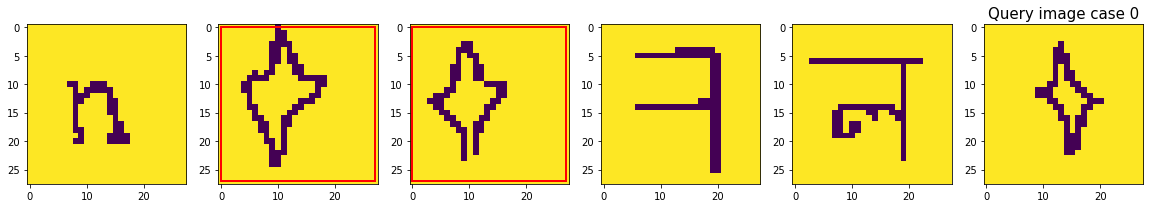

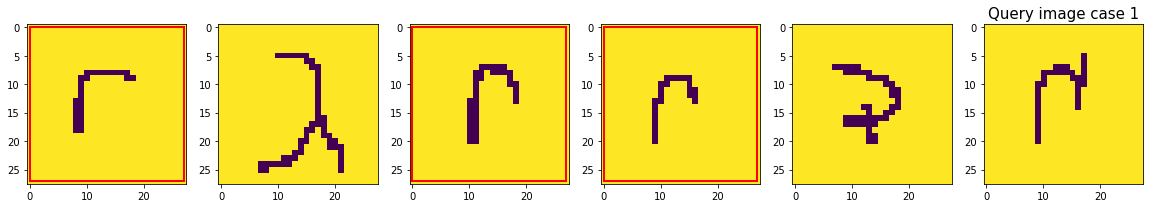

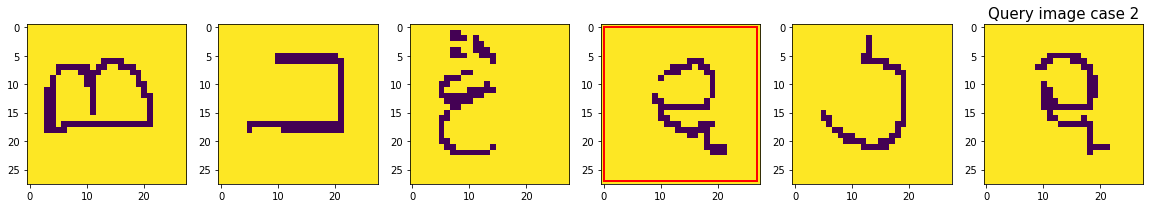

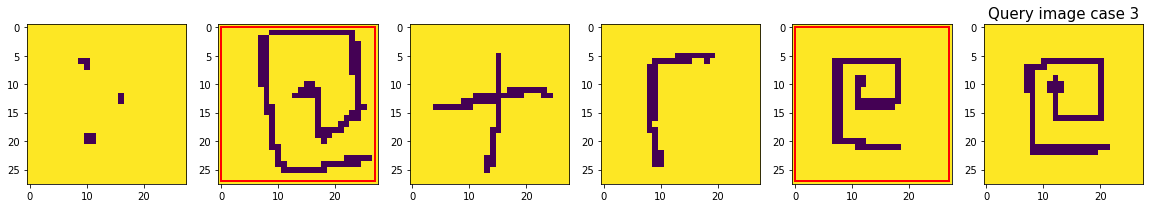

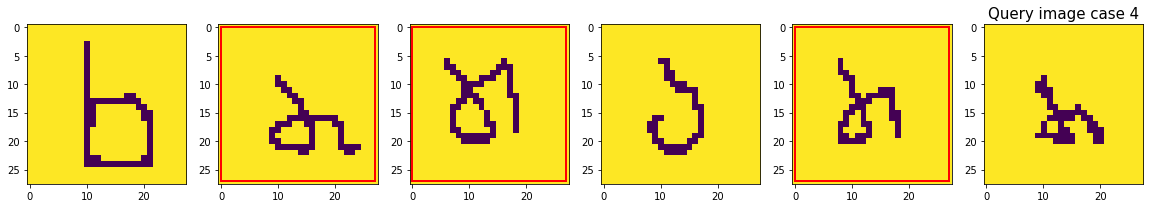

In [4]:
[plot_case(caseID,train_data,train_label) for caseID in range(5)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [5]:
    
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



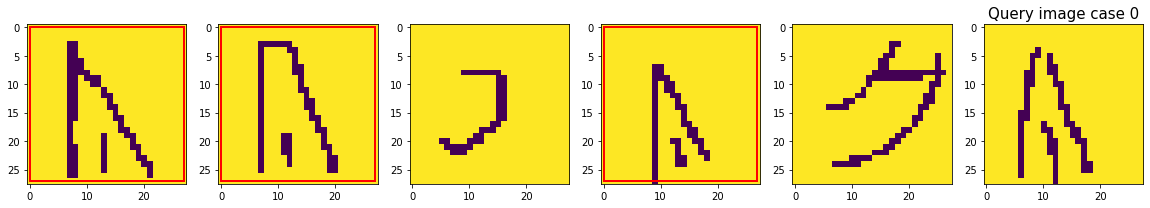

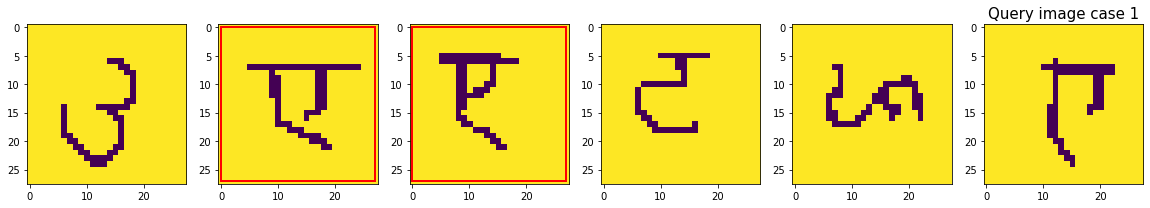

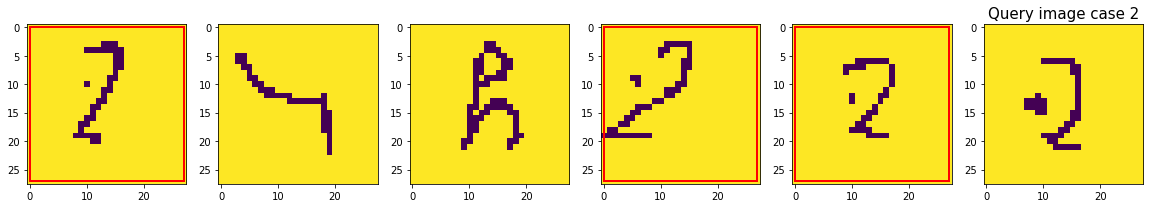

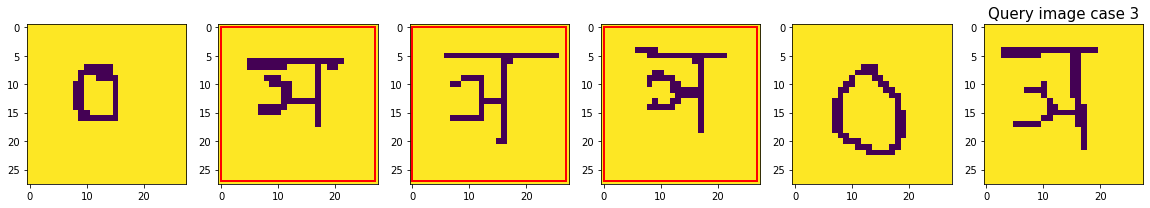

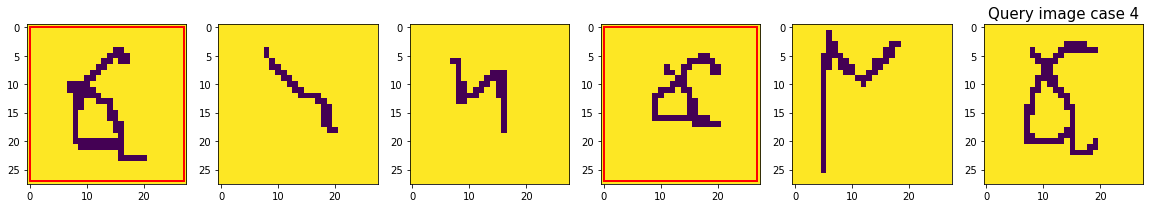

In [6]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

### Build pytorch dataset and dataload

In [7]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)
        self.transform = transform

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [8]:
from sklearn.model_selection import train_test_split
train_data, validation_data, train_label, validation_label = train_test_split(train_data, train_label, test_size=0.2)

In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
train_dataset=MyDataset(train_data,train_label, transform)
validation_dataset=MyDataset(validation_data,validation_label, transform)
test_dataset=MyDataset(test_data,test_label, transform)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=10)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

In [11]:
# What is the data loader output shape?
x_example, y_example = next(iter(torch.utils.data.DataLoader(train_dataset, batch_size=10)))
x_example.shape, y_example.shape

(torch.Size([10, 6, 28, 28]), torch.Size([10, 5]))

In [12]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Fitting/Training the model
def random_rotate(img):
    angle = random.choice([0, 90, 180, 270])
    return TF.rotate(img, angle)

def make_triplets(imgs, yb):
    '''
    For each tuple of imgs, create triples of (anchor, positive, negative).
    One triple for each positive, negatives are chosen randomly.
    '''
    # N = batch size
    N = imgs.shape[0]
    # print(N)
    anchors = []
    positives = []
    negatives = []
    # for each batch, get pos_yb and neg_yb. then for each positive, take a random negative
    for n in range(N):
        pos_yb = (yb[n, :] == 1).nonzero()
        neg_yb = (yb[n, :] == 0).nonzero()
        for pos_idx in pos_yb:
            # TODO: add data augmentation? by rotation
            anchors.append(imgs[n, -1].unsqueeze(0))
            # add 1 to the index because query is the first one
            positives.append(imgs[n, pos_idx])
            negatives.append(imgs[n, random.choice(neg_yb)])
            
    # Return N*r anchors, positives, negatives
    return [torch.cat(imgs) for imgs in [anchors, positives, negatives]]

def fit(epochs, loss_func, model, train_loader, val_loader, opt):
    threshold = 0.2105
    loss_graph = []
    val_loss_graph = []
    for epoch in range(epochs):
        model = model.train()
        print(f'Epoch {epoch + 1}')
        
        losses = []
        val_loss = []
        for imgs, yb in tqdm(train_loader, desc="Training"):
            opt.zero_grad()

            anchor, positive, negative = make_triplets(imgs, yb)
            # print(anchor.shape, positive.shape, negative.shape)
            # Then apply model to each of the three and use triplet loss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html(a, p, n)
            # http://www.bmva.org/bmvc/2016/papers/paper119/paper119.pdf
            if torch.cuda.is_available():
                anchor, positive, negative = [v.cuda() for v in [anchor, positive, negative]]
            
            anchor, positive, negative = [model(v) for v in [anchor, positive, negative]]
            
            loss = loss_func(anchor, positive, negative)

            # Backward and optimize
            loss.backward()
            opt.step()

            # Record data
            losses.append(loss.item() / anchor.shape[0])
        
        loss_graph.append(sum(losses) / len(train_loader))
        
        
        model = model.eval()
        for imval, ybval in val_loader:
            anchor, positive, negative = make_triplets(imval, ybval)
            
            if torch.cuda.is_available():
                anchor, positive, negative = [v.cuda() for v in [anchor, positive, negative]]
            
            anchor, positive, negative = [model(v) for v in [anchor, positive, negative]]
            
            loss = loss_func(anchor, positive, negative)
            val_loss.append(loss.item() / anchor.shape[0])
            

        val_loss_graph.append(sum(val_loss) / len(val_loader))
        print(f'Average loss: {loss_graph[-1]}')
        print(f'val loss: {val_loss_graph[-1]}')

        print('Train accuracy:' f'{(threshold, test(model, train_loader, threshold))}')
        print('Validation accuracy:' f'{(threshold, test(model, val_loader, threshold))}')
        # threshold_range = list(torch.linspace(0, 1, 5))
        # print(
            # 'Validation accuracy by threshold:'
            # f'{[(t.item(), test(model, val_loader, t)) for t in tqdm(threshold_range, desc="Validating")]}')

    plt.plot(loss_graph)
    plt.title("training loss")
    plt.xlabel("epoch number")
    plt.ylabel("loss value")


# TODO: show a couple examples of make_triplets

In [13]:
def test(model, test_loader, threshold=0.5):
    '''
    Test given model using data from given loader with given threshold.
    Return scores: (FP, TP, accuracy)
    '''
    model = model.eval()
    running_tp = 0.0
    running_fp = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for imgs, yb in test_loader:
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                yb = yb.cuda()

            # Embed each img
            query = model(imgs[:, -1])
            supports = []
            for col in range(imgs.shape[1] - 1):
                embed = model(imgs[:, col])
                supports.append(embed)

            # Calculate euclidean/cosine distance from query to each support
            cos = nn.CosineSimilarity()
            # distances = torch.stack([((query - sup)**2).sum(axis=1).sqrt() for sup in supports]).T
            distances = torch.stack([0.5 - (cos(query, sup) / 2.) for sup in supports]).T
            # Classify based on given threshold: if support is closer than threshold, it is the same
            # softmax of euclidean distances: https://arxiv.org/pdf/1703.05175.pdf
            # ratio measure via softmax: https://arxiv.org/pdf/1412.6622.pdf
            preds = (distances < threshold).float()
            # Receiver operating characteristic plots the true and false positives
            preds = preds.cuda()
            yb = yb.cuda()
            running_tp += (((preds == 1) & (yb == 1)).sum() / (yb == 1).sum()).item()
            running_fp += (((preds == 1) & (yb == 0)).sum() / (yb == 0).sum()).item()
            running_acc += ((preds == yb).sum() / yb.shape[0] / yb.shape[1]).item()
            
        n = len(test_loader)
        return (running_fp / n, running_tp / n, running_acc / n)

def plot_roc(model, loader, thresholds, desc="Validation"):
    rocs = [test(model, loader, t) for t in thresholds]
    # Split tuples into x and y, x = FP and y = TP
    x = [roc[0] for roc in rocs]
    y = [roc[1] for roc in rocs]
    # z = accuracy, is not plotted
    z = [roc[2] for roc in rocs]
    plt.plot(x, y)
    plt.title(f"{desc} ROC")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    return x, y, z

In [14]:
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

class OneModel(nn.Module):
    def __init__(self):
        super(OneModel, self).__init__()

    def forward(self, images):
        return torch.ones((images.shape[0], images.shape[1]))

class RandomModel(nn.Module):
    def __init__(self):
        super(RandomModel, self).__init__()

    def forward(self, images):
        return torch.randn((images.shape[0], images.shape[1]))

In [15]:
# The model

class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0]
        return x.view(N, -1)

class Model(nn.Module):
    # Examples: https://github.com/MSiam/Few-Shot-Learning
    def __init__(self):
        super(Model, self).__init__()
        channels = [1, 16, 64, 128]
        embedding_length = 32

        # Image is N x 28 x 28, N = batch size
        self.embed = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], 7, padding=3),
            nn.BatchNorm2d(channels[1]),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(channels[1], channels[2], 3, padding=1),
            nn.BatchNorm2d(channels[2]),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(channels[2], channels[3], 3, padding=1),
            nn.BatchNorm2d(channels[3]),
            nn.ReLU(),
            Flatten(),
            nn.Linear(7 * 7 * channels[3], embedding_length)
        )

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x = self.embed(x)
        return x

model = Model()
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(model)

The model architecture:

 Model(
  (embed): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Flatten()
    (12): Linear(in_features=6272, out_features=32, bias=True)
  )
)

The model has 285,088 trainable parameters


C:\Users\Pim\AppData\Local\Temp\ipykernel_8340\1979104940.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  temp = sum(p.numel() for p in model.parameters() if p.requires_grad)


OneModel stats
Train accuracy: (1.0, 1.0, 0.4002500161528587)
Validation accuracy: (1.0, 1.0, 0.39840001553297044)
Test accuracy: (1.0, 1.0, 0.38860001593828203)


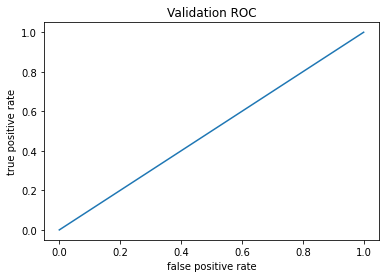

In [16]:
# Baseline: a model that always predicts 1 (same category for all support images)
print('OneModel stats')
print(f"Train accuracy: {test(OneModel(), train_loader, 0.5)}")
print(f"Validation accuracy: {test(OneModel(), validation_loader, 0.5)}")
print(f"Test accuracy: {test(OneModel(), test_loader, 0.5)}")

_ = plot_roc(OneModel(), validation_loader, torch.linspace(0, 1, 10))

Random model stats
Train accuracy: (0.4956641916930675, 0.5006606579944491, 0.5029250221326947)
Validation accuracy: (0.506942489221692, 0.4982846374064684, 0.49520002052187917)
Test accuracy: (0.502911334335804, 0.49497889786958693, 0.49620002090930937)


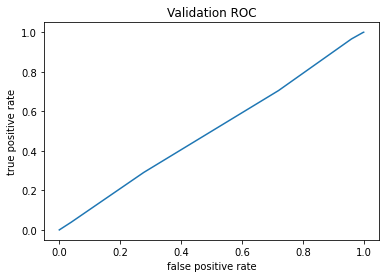

In [17]:
print('Random model stats')
print(f"Train accuracy: {test(RandomModel(), train_loader, 0.5)}")
print(f"Validation accuracy: {test(RandomModel(), validation_loader, 0.5)}")
print(f"Test accuracy: {test(RandomModel(), test_loader, 0.5)}")

_ = plot_roc(RandomModel(), validation_loader, torch.linspace(0, 1, 10))

Epoch 1


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:16<00:00, 49.10it/s]


Average loss: 0.022549854628705776
val loss: 0.020258114016141558
Train accuracy:(0.2105, (0.11944744467269629, 0.8204082398861646, 0.8563250429183245))
Validation accuracy:(0.2105, (0.12311822522431612, 0.7941038894653321, 0.8438000386953354))
Epoch 2


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 103.29it/s]


Average loss: 0.017092461084155044
val loss: 0.017334458881157543
Train accuracy:(0.2105, (0.10031065764138475, 0.8929803744703532, 0.8969250436127186))
Validation accuracy:(0.2105, (0.10435211145319044, 0.8697664488852024, 0.8852000436186791))
Epoch 3


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 101.68it/s]


Average loss: 0.015088350044145458
val loss: 0.015575456942434056
Train accuracy:(0.2105, (0.07608803673880175, 0.911225413158536, 0.9189000391215086))
Validation accuracy:(0.2105, (0.07840678163804114, 0.8757143685221672, 0.90310004144907))
Epoch 4


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 104.59it/s]


Average loss: 0.0134917201123621
val loss: 0.015047040075761131
Train accuracy:(0.2105, (0.06718276604544371, 0.9255145857483149, 0.9297750375419855))
Validation accuracy:(0.2105, (0.07128197324462235, 0.8862226995825767, 0.9115000393986702))
Epoch 5


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 107.95it/s]


Average loss: 0.01259174864392905
val loss: 0.014933534866188855
Train accuracy:(0.2105, (0.0633481461298652, 0.9382081940025091, 0.9371000350266695))
Validation accuracy:(0.2105, (0.0700737213715911, 0.8926876407861709, 0.9149000385403633))
Epoch 6


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 123.49it/s]


Average loss: 0.011898562652007465
val loss: 0.014522951285890715
Train accuracy:(0.2105, (0.05837726799305529, 0.9454535440355539, 0.9429750343412161))
Validation accuracy:(0.2105, (0.05935457310639322, 0.8942473354935646, 0.9222000393271447))
Epoch 7


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 117.94it/s]


Average loss: 0.01106181284977352
val loss: 0.014242721977577104
Train accuracy:(0.2105, (0.05449030106188729, 0.9505016309022903, 0.9473750330507755))
Validation accuracy:(0.2105, (0.059957712208852175, 0.8996909138560295, 0.9241000372171402))
Epoch 8


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 114.74it/s]


Average loss: 0.01069243035492621
val loss: 0.01453669403528361
Train accuracy:(0.2105, (0.05214894693810493, 0.9555576004087925, 0.9507500325143338))
Validation accuracy:(0.2105, (0.05807627604342997, 0.8991772857308388, 0.9250000375509262))
Epoch 9


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 114.46it/s]


Average loss: 0.010203447892584467
val loss: 0.014946052278570227
Train accuracy:(0.2105, (0.05296675670426339, 0.9631218259781599, 0.953275031298399))
Validation accuracy:(0.2105, (0.06407675291411578, 0.9171733871102333, 0.9286000400781631))
Epoch 10


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 118.28it/s]


Average loss: 0.009519366351349829
val loss: 0.014442519596536488
Train accuracy:(0.2105, (0.04812288315966726, 0.9651246628910303, 0.9569500303268432))
Validation accuracy:(0.2105, (0.05775821205228567, 0.911096148788929, 0.9299000400304794))
Epoch 11


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 119.65it/s]


Average loss: 0.00916123131959007
val loss: 0.014226817463273238
Train accuracy:(0.2105, (0.04497568229213357, 0.9623726633936167, 0.9578000305593014))
Validation accuracy:(0.2105, (0.05321951424703002, 0.9029552909731865, 0.9293000388145447))
Epoch 12


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 115.67it/s]


Average loss: 0.008686068981555448
val loss: 0.014497056733648506
Train accuracy:(0.2105, (0.039696942353621124, 0.9650172963738441, 0.9619250289350748))
Validation accuracy:(0.2105, (0.04998804520815611, 0.8983906605839729, 0.9292000392079354))
Epoch 13


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 112.46it/s]


Average loss: 0.008346676892517457
val loss: 0.014592882862921187
Train accuracy:(0.2105, (0.040723264508415014, 0.9703574022650718, 0.9634250274300575))
Validation accuracy:(0.2105, (0.05583570353686809, 0.9073115330934525, 0.9294000390172005))
Epoch 14


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 110.22it/s]


Average loss: 0.007870497736863939
val loss: 0.014585928674805224
Train accuracy:(0.2105, (0.03901546657783911, 0.9701703448593616, 0.9644000273942948))
Validation accuracy:(0.2105, (0.05426179243251681, 0.8943792892992497, 0.9255000403523446))
Epoch 15


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 116.35it/s]


Average loss: 0.007710515697588765
val loss: 0.014382800029947341
Train accuracy:(0.2105, (0.03652665293542668, 0.9684363554418087, 0.9651750267297029))
Validation accuracy:(0.2105, (0.052037275154143574, 0.8928046426177025, 0.9258000382781029))
Epoch 16


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 119.86it/s]


Average loss: 0.007251347555983725
val loss: 0.01560978439826232
Train accuracy:(0.2105, (0.03769090089015663, 0.9692372231185437, 0.9647750274091959))
Validation accuracy:(0.2105, (0.056923242323100566, 0.8911932337284089, 0.9224000373482704))
Epoch 17


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 117.54it/s]


Average loss: 0.006899494249512894
val loss: 0.014982063772379914
Train accuracy:(0.2105, (0.0361552298348397, 0.9732386744767427, 0.9673000257462263))
Validation accuracy:(0.2105, (0.053015491543337706, 0.8939577996730804, 0.9258000364899636))
Epoch 18


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 116.92it/s]


Average loss: 0.006636561693837477
val loss: 0.014698442413414937
Train accuracy:(0.2105, (0.03264635099563748, 0.9703074824810028, 0.9682750249654055))
Validation accuracy:(0.2105, (0.04679510632529855, 0.8829297655820847, 0.9250000369548798))
Epoch 19


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 115.12it/s]


Average loss: 0.006409864037126182
val loss: 0.01471886070926995
Train accuracy:(0.2105, (0.0309115505986847, 0.9691716308891773, 0.968800024613738))
Validation accuracy:(0.2105, (0.04678855285979808, 0.8835356286168099, 0.9255000379681587))
Epoch 20


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 117.07it/s]


Average loss: 0.006309579009902143
val loss: 0.015320472164164394
Train accuracy:(0.2105, (0.030029055948834867, 0.9672872454673052, 0.9685000245273113))
Validation accuracy:(0.2105, (0.04875371782109141, 0.8706870540976525, 0.9191000378131866))
Epoch 21


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 114.13it/s]


Average loss: 0.006037231486132455
val loss: 0.014998572480734405
Train accuracy:(0.2105, (0.028126637304667385, 0.9689923745393753, 0.9703500237315893))
Validation accuracy:(0.2105, (0.045475440761074425, 0.8754222282767296, 0.9230000403523445))
Epoch 22


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 114.03it/s]


Average loss: 0.005806415978809942
val loss: 0.015063453190275154
Train accuracy:(0.2105, (0.028244509296491742, 0.974600347802043, 0.9725250229984522))
Validation accuracy:(0.2105, (0.04773597627878189, 0.8771044430136681, 0.9224000391364098))
Epoch 23


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 116.12it/s]


Average loss: 0.005651385319966276
val loss: 0.015574398339925515
Train accuracy:(0.2105, (0.025404091889504342, 0.972009693980217, 0.9731500221043825))
Validation accuracy:(0.2105, (0.0437501648068428, 0.8670895448327065, 0.9209000399708748))
Epoch 24


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 115.45it/s]


Average loss: 0.0053488114130507015
val loss: 0.015426709082353565
Train accuracy:(0.2105, (0.026782677145674824, 0.9786756042391062, 0.975075021237135))
Validation accuracy:(0.2105, (0.05206515326164663, 0.8917405852675437, 0.9252000391483307))
Epoch 25


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 116.32it/s]


Average loss: 0.005210569475017652
val loss: 0.015148271785974013
Train accuracy:(0.2105, (0.024799675743561237, 0.9773598272353411, 0.9756500200927257))
Validation accuracy:(0.2105, (0.046959207924082876, 0.8730022975802422, 0.9208000400662422))
Epoch 26


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 115.69it/s]


Average loss: 0.004918234343420076
val loss: 0.01558484594924176
Train accuracy:(0.2105, (0.023487670407630504, 0.975742503106594, 0.9758000211417674))
Validation accuracy:(0.2105, (0.045885589038953185, 0.8607577204704284, 0.9167000415921212))
Epoch 27


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 114.28it/s]


Average loss: 0.0049222607592036794
val loss: 0.01543238893398998
Train accuracy:(0.2105, (0.023080057525075973, 0.97617371276021, 0.9762000205367803))
Validation accuracy:(0.2105, (0.04644764945842326, 0.8668165636062622, 0.9189000385999679))
Epoch 28


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 117.86it/s]


Average loss: 0.004768566636023697
val loss: 0.01572153962707453
Train accuracy:(0.2105, (0.021065259496681393, 0.9750264229625464, 0.9769750197976828))
Validation accuracy:(0.2105, (0.04296935340389609, 0.8554607370495796, 0.9164000430703163))
Epoch 29


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 110.77it/s]


Average loss: 0.004471787325712018
val loss: 0.014959640248177211
Train accuracy:(0.2105, (0.020760313062928616, 0.9788983476161957, 0.9786000185459852))
Validation accuracy:(0.2105, (0.04073485699482262, 0.8553511828184128, 0.9178000405430794))
Epoch 30


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 116.25it/s]


Average loss: 0.00432346724831822
val loss: 0.01629549818871527
Train accuracy:(0.2105, (0.021764099535066635, 0.9788883163779974, 0.9780750186741352))
Validation accuracy:(0.2105, (0.04705817461013794, 0.870634703040123, 0.9199000409245491))
Epoch 31


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 113.60it/s]


Average loss: 0.004302047417933127
val loss: 0.01617500539591424
Train accuracy:(0.2105, (0.02099027351010591, 0.9816616255044938, 0.9797250181436539))
Validation accuracy:(0.2105, (0.05315282067283988, 0.8727446603775024, 0.9172000402212143))
Epoch 32


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 111.26it/s]


Average loss: 0.004081442529986511
val loss: 0.015687081178555596
Train accuracy:(0.2105, (0.01775568093638867, 0.9763696023821831, 0.97940001770854))
Validation accuracy:(0.2105, (0.0381522005610168, 0.8448804315924644, 0.914900039434433))
Epoch 33


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 98.01it/s]


Average loss: 0.003989497839221341
val loss: 0.016168266199971203
Train accuracy:(0.2105, (0.01825323149561882, 0.9778522220999002, 0.9797750179469585))
Validation accuracy:(0.2105, (0.04503168793395162, 0.852833546102047, 0.9142000439763069))
Epoch 34


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 99.21it/s]


Average loss: 0.0038555996928278024
val loss: 0.016019914698510503
Train accuracy:(0.2105, (0.01813857364002615, 0.9767325890064239, 0.9792750176042319))
Validation accuracy:(0.2105, (0.03951956674456596, 0.8430009371042252, 0.9136000430583954))
Epoch 35


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 100.81it/s]


Average loss: 0.0037117805993625245
val loss: 0.01633712307195108
Train accuracy:(0.2105, (0.017556054366286843, 0.9713299158215523, 0.9774000193178654))
Validation accuracy:(0.2105, (0.03994478856213391, 0.8309277194738388, 0.9084000432491303))
Epoch 36


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 101.25it/s]


Average loss: 0.0037196910544704605
val loss: 0.015804531521872844
Train accuracy:(0.2105, (0.016788009121082723, 0.9800676607340574, 0.9814750162512064))
Validation accuracy:(0.2105, (0.04357344700023532, 0.8481519109010697, 0.9131000405550003))
Epoch 37


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 100.53it/s]


Average loss: 0.0035782186760845935
val loss: 0.016310745210660914
Train accuracy:(0.2105, (0.016264004951808603, 0.9768383405357599, 0.9806250166893006))
Validation accuracy:(0.2105, (0.040032386938109996, 0.8399259877204895, 0.9121000424027443))
Epoch 38


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 101.56it/s]


Average loss: 0.0034642999929098057
val loss: 0.01618855496700534
Train accuracy:(0.2105, (0.01612603962421417, 0.9808690349757672, 0.9822500157356262))
Validation accuracy:(0.2105, (0.04189118015579879, 0.8428901660442353, 0.9121000403165818))
Epoch 39


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 101.65it/s]


Average loss: 0.0033614779602743
val loss: 0.016352550325054113
Train accuracy:(0.2105, (0.01612743203062564, 0.9811493781208992, 0.9823250155895948))
Validation accuracy:(0.2105, (0.04050378052517772, 0.8409642782807351, 0.9120000407099724))
Epoch 40


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 102.04it/s]


Average loss: 0.003269883563963062
val loss: 0.01653121612930676
Train accuracy:(0.2105, (0.015142909423448146, 0.9804583073407411, 0.9827250154316425))
Validation accuracy:(0.2105, (0.040965117495507, 0.8373151445388793, 0.9101000431180001))
Epoch 41


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 103.90it/s]


Average loss: 0.0030772813077983973
val loss: 0.01677410346512935
Train accuracy:(0.2105, (0.014148525998461992, 0.9789453472942113, 0.9826500157266855))
Validation accuracy:(0.2105, (0.04004460019059479, 0.8253206081688405, 0.9060000428557395))
Epoch 42


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 104.65it/s]


Average loss: 0.002985600645930066
val loss: 0.016889340767141596
Train accuracy:(0.2105, (0.013777899136766792, 0.9800272803753615, 0.9832750151306391))
Validation accuracy:(0.2105, (0.03622833359986544, 0.8236894100904465, 0.9075000423192978))
Epoch 43


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 103.65it/s]


Average loss: 0.0029259468317013814
val loss: 0.016384274298110974
Train accuracy:(0.2105, (0.013347361097112298, 0.9795831678807736, 0.9833500149101019))
Validation accuracy:(0.2105, (0.037958853505551816, 0.8277156287431717, 0.9080000415444374))
Epoch 44


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 104.66it/s]


Average loss: 0.0029157240636231694
val loss: 0.01640725664537788
Train accuracy:(0.2105, (0.01376078619621694, 0.9786128472536803, 0.982775015309453))
Validation accuracy:(0.2105, (0.038160659987479445, 0.8270468312501907, 0.9081000378727913))
Epoch 45


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 102.89it/s]


Average loss: 0.0028181600794100247
val loss: 0.016447284100961558
Train accuracy:(0.2105, (0.012295468209777028, 0.9825362876802682, 0.9853250133246183))
Validation accuracy:(0.2105, (0.03932769837789238, 0.8356243667006492, 0.910500040948391))
Epoch 46


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 100.63it/s]


Average loss: 0.0026959998205328605
val loss: 0.017065530005907107
Train accuracy:(0.2105, (0.0128173525352031, 0.9809250424057245, 0.9843000138550997))
Validation accuracy:(0.2105, (0.04196130177937448, 0.8271007281541825, 0.9056000417470932))
Epoch 47


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 103.51it/s]


Average loss: 0.0026255517525930736
val loss: 0.016645499939248107
Train accuracy:(0.2105, (0.012251498075202108, 0.981008730456233, 0.9846250139176845))
Validation accuracy:(0.2105, (0.040169050144031646, 0.8344216760993004, 0.909700039923191))
Epoch 48


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 103.98it/s]


Average loss: 0.0026275345140233954
val loss: 0.017133951198397758
Train accuracy:(0.2105, (0.011899611139670014, 0.9793111050873995, 0.9841250143945217))
Validation accuracy:(0.2105, (0.039399329712614416, 0.817122277021408, 0.9033000409603119))
Epoch 49


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 104.03it/s]


Average loss: 0.0024535808114004246
val loss: 0.01659816334797105
Train accuracy:(0.2105, (0.011782750964630394, 0.9804739607125521, 0.9847250138223171))
Validation accuracy:(0.2105, (0.03886950040236115, 0.8212256371974945, 0.905000039935112))
Epoch 50


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 103.05it/s]


Average loss: 0.0024007630105548016
val loss: 0.016887349577091485
Train accuracy:(0.2105, (0.010926685906015336, 0.9814460869133472, 0.9856750132143497))
Validation accuracy:(0.2105, (0.03784669045358896, 0.8087231329083443, 0.9007000395655632))
Epoch 51


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 100.60it/s]


Average loss: 0.0024348765050690134
val loss: 0.017070856760191794
Train accuracy:(0.2105, (0.010062729911878706, 0.9806554397195577, 0.9859000128507615))
Validation accuracy:(0.2105, (0.03949846539646387, 0.811959376335144, 0.9010000431537628))
Epoch 52


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 102.53it/s]


Average loss: 0.002348811980006796
val loss: 0.016899506454396803
Train accuracy:(0.2105, (0.011059944725129753, 0.982851712629199, 0.9861750122904778))
Validation accuracy:(0.2105, (0.03992183651775122, 0.8176931568980217, 0.9027000403404236))
Epoch 53


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 101.70it/s]


Average loss: 0.0022821678072475087
val loss: 0.016964313392043667
Train accuracy:(0.2105, (0.010171940294094383, 0.979873111769557, 0.9854750130325556))
Validation accuracy:(0.2105, (0.04121332112699747, 0.8174777135252953, 0.9020000398159027))
Epoch 54


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 102.37it/s]


Average loss: 0.0022636722109018125
val loss: 0.01748184642967033
Train accuracy:(0.2105, (0.009733380598481745, 0.9810517624020576, 0.9861750125139952))
Validation accuracy:(0.2105, (0.038217517733573916, 0.8044396315515041, 0.8986000424623489))
Epoch 55


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 102.09it/s]


Average loss: 0.002124640334083068
val loss: 0.016939603047164974
Train accuracy:(0.2105, (0.009834826157893986, 0.9787305796146393, 0.9852750132977962))
Validation accuracy:(0.2105, (0.03598752784542739, 0.7953898964822292, 0.8967000421881676))
Epoch 56


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 100.65it/s]


Average loss: 0.00209284334635499
val loss: 0.01730638382679699
Train accuracy:(0.2105, (0.009843968041241168, 0.9800919952243566, 0.9857250128686428))
Validation accuracy:(0.2105, (0.039720651395618915, 0.8007606941461564, 0.896200041770935))
Epoch 57


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 100.60it/s]


Average loss: 0.002130800421794718
val loss: 0.017207629473552474
Train accuracy:(0.2105, (0.008703565809410065, 0.9801477567106486, 0.9864500120282174))
Validation accuracy:(0.2105, (0.037298644306138155, 0.7996151006221771, 0.897100042104721))
Epoch 58


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 100.38it/s]


Average loss: 0.0019828137000973273
val loss: 0.017320034330972636
Train accuracy:(0.2105, (0.008829083188902586, 0.9790595162659883, 0.9859500125795603))
Validation accuracy:(0.2105, (0.03540397128090263, 0.8006457430124283, 0.8985000425577163))
Epoch 59


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 97.48it/s]


Average loss: 0.0020194461709630157
val loss: 0.017049528024435684
Train accuracy:(0.2105, (0.008628545196261257, 0.9794658468663693, 0.9862500122189521))
Validation accuracy:(0.2105, (0.03677716756239533, 0.7996572069823742, 0.8977000421285629))
Epoch 60


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 101.54it/s]


Average loss: 0.0019835915456230054
val loss: 0.01811149901287668
Train accuracy:(0.2105, (0.007926854165270924, 0.9773888622969389, 0.985800012499094))
Validation accuracy:(0.2105, (0.04106687421910465, 0.7927157884836197, 0.892400040924549))
Epoch 61


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 91.29it/s]


Average loss: 0.0019122080881014503
val loss: 0.017376153742558995
Train accuracy:(0.2105, (0.0077361629158258435, 0.9807869452983141, 0.9873500113934278))
Validation accuracy:(0.2105, (0.034028149032965305, 0.7948656977713108, 0.8972000399231911))
Epoch 62


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 90.64it/s]


Average loss: 0.0017944135708440956
val loss: 0.017226262396301362
Train accuracy:(0.2105, (0.007645307614002377, 0.9802591428905726, 0.9871750114858151))
Validation accuracy:(0.2105, (0.0369558834284544, 0.7948331926763058, 0.8957000443339348))
Epoch 63


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 92.62it/s]


Average loss: 0.0017953962571408061
val loss: 0.017741140460586377
Train accuracy:(0.2105, (0.006876374345738441, 0.9764662145823241, 0.986100012511015))
Validation accuracy:(0.2105, (0.03398745864629746, 0.7757446198165416, 0.8901000428199768))
Epoch 64


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 91.72it/s]


Average loss: 0.0017436826959828617
val loss: 0.01716024706913462
Train accuracy:(0.2105, (0.007630790024995804, 0.9763142538070678, 0.9855250126868487))
Validation accuracy:(0.2105, (0.03461469595320523, 0.7847148212790489, 0.8931000408530235))
Epoch 65


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:09<00:00, 87.16it/s]


Average loss: 0.0016649081579117112
val loss: 0.01785555502863462
Train accuracy:(0.2105, (0.007551084642764181, 0.977271082252264, 0.9859250128269196))
Validation accuracy:(0.2105, (0.0344139529298991, 0.7689908158779144, 0.8868000420928002))
Epoch 66


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 55.57it/s]


Average loss: 0.0017078253167387603
val loss: 0.018081439032320318
Train accuracy:(0.2105, (0.007011040123179555, 0.9763992454856634, 0.9858750125765801))
Validation accuracy:(0.2105, (0.03627634020522237, 0.763905316144228, 0.8833000433444976))
Epoch 67


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 50.44it/s]


Average loss: 0.0016455699013096332
val loss: 0.01790433468144078
Train accuracy:(0.2105, (0.006297814077697694, 0.9766865946352482, 0.9864750121533871))
Validation accuracy:(0.2105, (0.0355160478875041, 0.7788976991176605, 0.8899000418186188))
Epoch 68


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 54.03it/s]


Average loss: 0.001599745046379078
val loss: 0.017860044328879145
Train accuracy:(0.2105, (0.00630869714776054, 0.9785672520101071, 0.9872500111162662))
Validation accuracy:(0.2105, (0.03594850545749068, 0.7705100667476654, 0.8863000425696373))
Epoch 69


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 54.36it/s]


Average loss: 0.0015509797585321289
val loss: 0.017965036058314784
Train accuracy:(0.2105, (0.006154171491507441, 0.976196441501379, 0.9864500120282174))
Validation accuracy:(0.2105, (0.03627799736335874, 0.7717335161566734, 0.8867000436782837))
Epoch 70


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 55.38it/s]


Average loss: 0.0015326503014333704
val loss: 0.01789104538677979
Train accuracy:(0.2105, (0.00603866949910298, 0.9769477491825819, 0.9868000119179487))
Validation accuracy:(0.2105, (0.0358750612474978, 0.7698868389427662, 0.8860000407695771))
Epoch 71


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:13<00:00, 58.16it/s]


Average loss: 0.0015371032953199074
val loss: 0.018356042781320855
Train accuracy:(0.2105, (0.006201483504846692, 0.9750024361908436, 0.985825012177229))
Validation accuracy:(0.2105, (0.034125160751864315, 0.7677037219703198, 0.8865000426769256))
Epoch 72


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:12<00:00, 64.89it/s]


Average loss: 0.0014642189708192715
val loss: 0.017981800180213666
Train accuracy:(0.2105, (0.005777328109834343, 0.9771478793025017, 0.9870750113576651))
Validation accuracy:(0.2105, (0.03518336314707995, 0.7636986513435841, 0.884300044476986))
Epoch 73


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:12<00:00, 63.60it/s]


Average loss: 0.0014551894013814027
val loss: 0.01777173833166241
Train accuracy:(0.2105, (0.0059479925176128745, 0.9762652771174908, 0.9865750120580197))
Validation accuracy:(0.2105, (0.03654238815419376, 0.7655847050249577, 0.8840000429749488))
Epoch 74


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:12<00:00, 65.98it/s]


Average loss: 0.001467493439218378
val loss: 0.018039639068841345
Train accuracy:(0.2105, (0.005458120699040591, 0.9786973859369755, 0.9878250106424094))
Validation accuracy:(0.2105, (0.03444443558342755, 0.7760496212542057, 0.8898000440001488))
Epoch 75


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:12<00:00, 61.91it/s]


Average loss: 0.0013447251070589788
val loss: 0.017845061917493302
Train accuracy:(0.2105, (0.005632686733733862, 0.9750378669053316, 0.98620001219213))
Validation accuracy:(0.2105, (0.03267160261981189, 0.7739244662225246, 0.8898000410199165))
Epoch 76


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 55.26it/s]


Average loss: 0.0013273562355552637
val loss: 0.01839191338219484
Train accuracy:(0.2105, (0.005466645481064915, 0.9788585402816534, 0.9878750110417605))
Validation accuracy:(0.2105, (0.03642720226198435, 0.7692147073149681, 0.8857000407576561))
Epoch 77


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 54.82it/s]


Average loss: 0.001346129556259683
val loss: 0.018009818739279326
Train accuracy:(0.2105, (0.005285694538615644, 0.9752756537497044, 0.986500011831522))
Validation accuracy:(0.2105, (0.03396280186250806, 0.7669329471886158, 0.8860000446438789))
Epoch 78


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 101.09it/s]


Average loss: 0.0013179389939057115
val loss: 0.018133440503150928
Train accuracy:(0.2105, (0.004637206695042551, 0.9791751169413329, 0.9884750101715326))
Validation accuracy:(0.2105, (0.032565663671121, 0.7637306796014309, 0.8858000436425209))
Epoch 79


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:13<00:00, 58.28it/s]


Average loss: 0.0013283251603875689
val loss: 0.01845202616081665
Train accuracy:(0.2105, (0.0048297590063884855, 0.9778030820935965, 0.98785001039505))
Validation accuracy:(0.2105, (0.03606597394682467, 0.767483393996954, 0.885300041437149))
Epoch 80


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 54.73it/s]


Average loss: 0.0012175699369236731
val loss: 0.018423687260384125
Train accuracy:(0.2105, (0.004559254623018205, 0.9744890308380127, 0.9866500115394592))
Validation accuracy:(0.2105, (0.03396064005792141, 0.747360598295927, 0.8780000418424606))
Epoch 81


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 54.98it/s]


Average loss: 0.0012976276408654388
val loss: 0.018570785501443424
Train accuracy:(0.2105, (0.004062729720026255, 0.9729922329634428, 0.9864250116795301))
Validation accuracy:(0.2105, (0.03220978796482086, 0.737488426566124, 0.8752000430226325))
Epoch 82


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 53.38it/s]


Average loss: 0.0012633347194033063
val loss: 0.018181545269932247
Train accuracy:(0.2105, (0.004632525846827776, 0.9742840805649757, 0.9864500121027231))
Validation accuracy:(0.2105, (0.03199773842468858, 0.7499402695894242, 0.8805000415444374))
Epoch 83


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 56.80it/s]


Average loss: 0.0012329308519711058
val loss: 0.01853792245096884
Train accuracy:(0.2105, (0.0043561600963585075, 0.9734269952774048, 0.9863750120997429))
Validation accuracy:(0.2105, (0.03277948956936598, 0.7414649108052254, 0.8769000387191772))
Epoch 84


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:13<00:00, 59.44it/s]


Average loss: 0.0010954226043617616
val loss: 0.01879362905760379
Train accuracy:(0.2105, (0.004553239741362632, 0.975773611292243, 0.9871500109136104))
Validation accuracy:(0.2105, (0.03405329580418766, 0.7551907989382743, 0.881400043964386))
Epoch 85


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:11<00:00, 69.42it/s]


Average loss: 0.0011227515381833843
val loss: 0.018408914307629514
Train accuracy:(0.2105, (0.004294603511225432, 0.9750474961847067, 0.9871750114113093))
Validation accuracy:(0.2105, (0.03426609454676509, 0.7532038345932961, 0.880600046813488))
Epoch 86


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.77it/s]


Average loss: 0.0011199429182283196
val loss: 0.01903108177183471
Train accuracy:(0.2105, (0.003814189205877483, 0.9725462490320206, 0.9863500119745732))
Validation accuracy:(0.2105, (0.03244091444648802, 0.7330623497068882, 0.8735000422596931))
Epoch 87


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 55.04it/s]


Average loss: 0.0010853247388425125
val loss: 0.018604746854034772
Train accuracy:(0.2105, (0.004675587813835591, 0.976555556729436, 0.9875000112503767))
Validation accuracy:(0.2105, (0.03390825366601348, 0.7405845937132836, 0.875700041949749))
Epoch 88


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 54.30it/s]


Average loss: 0.001058796810733579
val loss: 0.01826165583805454
Train accuracy:(0.2105, (0.003657245722133666, 0.9792607124149799, 0.9891250095516443))
Validation accuracy:(0.2105, (0.03321082655340433, 0.7502079291641712, 0.8799000445008278))
Epoch 89


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:16<00:00, 49.88it/s]


Average loss: 0.0010210500027331157
val loss: 0.01858346945544145
Train accuracy:(0.2105, (0.003663760698400438, 0.9767413768917322, 0.9881500106304884))
Validation accuracy:(0.2105, (0.030853229211643338, 0.737805755585432, 0.8762000441551209))
Epoch 90


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 54.05it/s]


Average loss: 0.001005319904471625
val loss: 0.018823409420605258
Train accuracy:(0.2105, (0.003674608648288995, 0.9739364701509475, 0.9870250112563371))
Validation accuracy:(0.2105, (0.03617495954968035, 0.7355309092998504, 0.8726000422239304))
Epoch 91


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 56.39it/s]


Average loss: 0.0009513141055267983
val loss: 0.018802118633322623
Train accuracy:(0.2105, (0.0036667722999118267, 0.9729030837863684, 0.9865250117331743))
Validation accuracy:(0.2105, (0.030940087912604212, 0.7324972935020924, 0.8743000441789627))
Epoch 92


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:13<00:00, 57.28it/s]


Average loss: 0.000938765758152478
val loss: 0.019161994125785026
Train accuracy:(0.2105, (0.0039022577367722987, 0.9758801505714655, 0.9876000111550093))
Validation accuracy:(0.2105, (0.03492102432064712, 0.743469251692295, 0.8761000418663025))
Epoch 93


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:09<00:00, 88.47it/s]


Average loss: 0.0009096486004735885
val loss: 0.01881648430103431
Train accuracy:(0.2105, (0.0035211657802574335, 0.971534620821476, 0.9861250119656324))
Validation accuracy:(0.2105, (0.03311462994664907, 0.7223191778361797, 0.8684000426530838))
Epoch 94


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 101.11it/s]


Average loss: 0.0009760563989431221
val loss: 0.018837305321231644
Train accuracy:(0.2105, (0.003531492801848799, 0.9746081141382456, 0.9873000109195709))
Validation accuracy:(0.2105, (0.03155744479969144, 0.7243820628523827, 0.8704000449180603))
Epoch 95


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 101.29it/s]


Average loss: 0.0009604281014815575
val loss: 0.018896293613890454
Train accuracy:(0.2105, (0.00387365338858217, 0.9771446194499731, 0.9881000103056431))
Validation accuracy:(0.2105, (0.03339743657968938, 0.7366597256064416, 0.8745000469684601))
Epoch 96


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:13<00:00, 59.03it/s]


Average loss: 0.0008540020826055519
val loss: 0.018823723117269972
Train accuracy:(0.2105, (0.0036287756194360553, 0.9749624722450971, 0.9874000106751919))
Validation accuracy:(0.2105, (0.03259069406427443, 0.7291321651637555, 0.8718000414967537))
Epoch 97


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 54.58it/s]


Average loss: 0.0008886956842143433
val loss: 0.019624252802323165
Train accuracy:(0.2105, (0.0030503481905907394, 0.9768014848977328, 0.9885500099509954))
Validation accuracy:(0.2105, (0.0309765653219074, 0.733494803160429, 0.8743000409007072))
Epoch 98


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:12<00:00, 62.58it/s]


Average loss: 0.0009189388229715626
val loss: 0.018918406551277845
Train accuracy:(0.2105, (0.0028431257838383316, 0.9742170290648937, 0.9874750109016895))
Validation accuracy:(0.2105, (0.03261234150268137, 0.7155251869559288, 0.8664000406861305))
Epoch 99


Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 54.61it/s]


Average loss: 0.0008485616086761805
val loss: 0.018802650944029504
Train accuracy:(0.2105, (0.003076587691903114, 0.9749816864728927, 0.9877750106155873))
Validation accuracy:(0.2105, (0.03115172352641821, 0.722273727953434, 0.8699000382423401))
Epoch 100


Training: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 103.44it/s]


Average loss: 0.0008841501273546841
val loss: 0.01919239109830811
Train accuracy:(0.2105, (0.003365735311526805, 0.9729271727800369, 0.9867000113427639))
Validation accuracy:(0.2105, (0.03130595470778644, 0.7241250459849834, 0.8706000408530236))


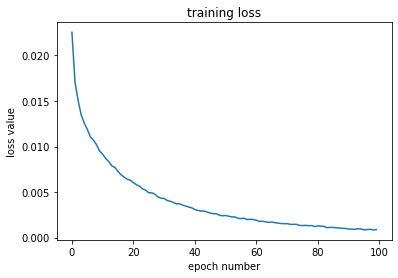

In [18]:
model = Model()

threshold = 1
loss_func = nn.TripletMarginWithDistanceLoss(
    distance_function=lambda x,y: 1. - F.cosine_similarity(x, y), margin=threshold)

if torch.cuda.is_available():
    model = model.cuda()
    loss_func = loss_func.cuda()

# The optimizer
from torch.optim import AdamW, SGD

# optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.005)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9)

epochs = 100
fit(epochs, loss_func, model, train_loader, validation_loader, optimizer)

Max accuracy: 0.9917000079154968


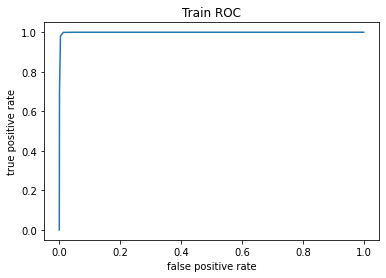

In [19]:
results = plot_roc(model, train_loader, torch.linspace(0, 1, 10), desc="Train")
print(f'Max accuracy: {max(results[2])}')

Max accuracy: 0.8931000429391861


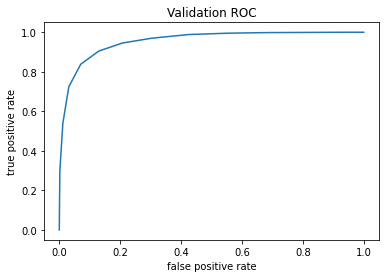

In [20]:
# Search for a good threshold on the validation set
threshold_search = list(torch.linspace(0, 1, 20))
fps, tps, accs = plot_roc(model, validation_loader, threshold_search, desc="Validation")
print(f'Max accuracy: {max(accs)}')

In [21]:
# The best point is the one closest to (0, 1) on the fp/tp curve
qualities = [1 - (fp ** 2 + (1 - tp) ** 2) for fp, tp in zip(fps, tps)]
best_threshold = threshold_search[max(range(len(qualities)), key=lambda i: qualities[i])]
print(f'Best threshold is {best_threshold}')
res = test(model, test_loader, best_threshold)
print(f'FP/TP/acc is {res}')

Best threshold is 0.31578946113586426
FP/TP/acc is (0.14052042277529836, 0.8460852986574173, 0.8542000436782837)


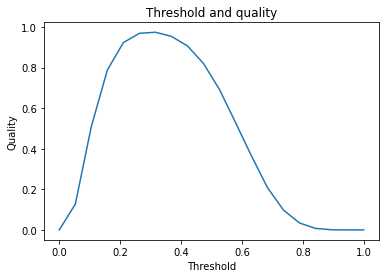

In [22]:
plt.plot(threshold_search, qualities)
plt.ylabel("Quality")
plt.xlabel("Threshold")
plt.title("Threshold and quality")
plt.show()

In [16]:
val_loss_graph = [0.020258114016141558, 0.017334458881157543, 0.015575456942434056, 0.015047040075761131, 0.014933534866188855, 0.014522951285890715, 0.014242721977577104, 0.01453669403528361, 0.014946052278570227, 0.014442519596536488, 0.014226817463273238, 0.014497056733648506, 0.014592882862921187, 0.014585928674805224, 0.014382800029947341, 0.01560978439826232, 0.014982063772379914, 0.014698442413414937, 0.01471886070926995, 0.015320472164164394, 0.014998572480734405, 0.015063453190275154, 0.015574398339925515, 0.015426709082353565, 0.015148271785974013, 0.01558484594924176, 0.01543238893398998, 0.01572153962707453, 0.014959640248177211, 0.01629549818871527, 0.01617500539591424, 0.015687081178555596, 0.016168266199971203, 0.016019914698510503, 0.01633712307195108, 0.015804531521872844, 0.016310745210660914, 0.01618855496700534, 0.016352550325054113, 0.01653121612930676, 0.01677410346512935, 0.016889340767141596, 0.016384274298110974, 0.01640725664537788, 0.016447284100961558, 0.017065530005907107, 0.016645499939248107, 0.017133951198397758, 0.01659816334797105, 0.016887349577091485, 0.017070856760191794, 0.016899506454396803, 0.016964313392043667, 0.01748184642967033, 0.016939603047164974, 0.01730638382679699, 0.017207629473552474, 0.017320034330972636, 0.017049528024435684, 0.01811149901287668, 0.017376153742558995, 0.017226262396301362, 0.017741140460586377, 0.01716024706913462, 0.01785555502863462, 0.018081439032320318, 0.01790433468144078, 0.017860044328879145, 0.017965036058314784, 0.01789104538677979, 0.018356042781320855, 0.017981800180213666, 0.01777173833166241, 0.018039639068841345, 0.017845061917493302, 0.01839191338219484, 0.018009818739279326, 0.018133440503150928, 0.01845202616081665, 0.018423687260384125, 0.018570785501443424, 0.018181545269932247, 0.01853792245096884, 0.01879362905760379, 0.018408914307629514, 0.01903108177183471, 0.018604746854034772, 0.01826165583805454, 0.01858346945544145, 0.018823409420605258, 0.018802118633322623, 0.019161994125785026, 0.01881648430103431, 0.018837305321231644, 0.018896293613890454, 0.018823723117269972, 0.019624252802323165, 0.018918406551277845, 0.018802650944029504, 0.01919239109830811]

In [17]:
loss_graph =  [0.022549854628705776, 0.017092461084155044, 0.015088350044145458, 0.0134917201123621, 0.01259174864392905, 0.011898562652007465, 0.01106181284977352, 0.01069243035492621, 0.010203447892584467, 0.009519366351349829, 0.00916123131959007, 0.008686068981555448, 0.008346676892517457, 0.007870497736863939, 0.007710515697588765, 0.007251347555983725, 0.006899494249512894, 0.006636561693837477, 0.006409864037126182, 0.006309579009902143, 0.006037231486132455, 0.005806415978809942, 0.005651385319966276, 0.0053488114130507015, 0.005210569475017652, 0.004918234343420076, 0.0049222607592036794, 0.004768566636023697, 0.004471787325712018, 0.00432346724831822, 0.004302047417933127, 0.004081442529986511, 0.003989497839221341, 0.0038555996928278024, 0.0037117805993625245, 0.0037196910544704605, 0.0035782186760845935, 0.0034642999929098057, 0.0033614779602743, 0.003269883563963062, 0.0030772813077983973, 0.002985600645930066, 0.0029259468317013814, 0.0029157240636231694, 0.0028181600794100247, 0.0026959998205328605, 0.0026255517525930736, 0.0026275345140233954, 0.0024535808114004246, 0.0024007630105548016, 0.0024348765050690134, 0.002348811980006796, 0.0022821678072475087, 0.0022636722109018125, 0.002124640334083068, 0.00209284334635499, 0.002130800421794718, 0.0019828137000973273, 0.0020194461709630157, 0.0019835915456230054, 0.0019122080881014503, 0.0017944135708440956, 0.0017953962571408061, 0.0017436826959828617, 0.0016649081579117112, 0.0017078253167387603, 0.0016455699013096332, 0.001599745046379078, 0.0015509797585321289, 0.0015326503014333704, 0.0015371032953199074, 0.0014642189708192715, 0.0014551894013814027, 0.001467493439218378, 0.0013447251070589788, 0.0013273562355552637, 0.001346129556259683, 0.0013179389939057115, 0.0013283251603875689, 0.0012175699369236731, 0.0012976276408654388, 0.0012633347194033063, 0.0012329308519711058,0.0010954226043617616, 0.0011227515381833843, 0.0011199429182283196, 0.0010853247388425125, 0.001058796810733579, 0.0010210500027331157, 0.001005319904471625, 0.0009513141055267983, 0.000938765758152478, 0.0009096486004735885, 0.0009760563989431221, 0.0009604281014815575, 0.0008540020826055519, 0.0008886956842143433, 0.0009189388229715626, 0.0008485616086761805, 0.0008841501273546841]

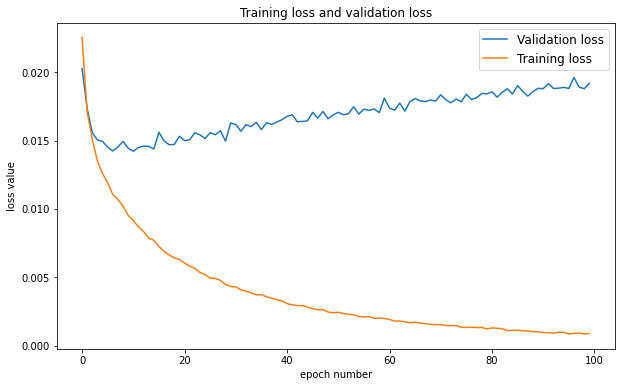

In [21]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.plot(val_loss_graph, label="Validation loss")
plt.plot(loss_graph, label="Training loss")
plt.title("Training loss and validation loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")
plt.legend(loc="upper right", prop={'size': 12})

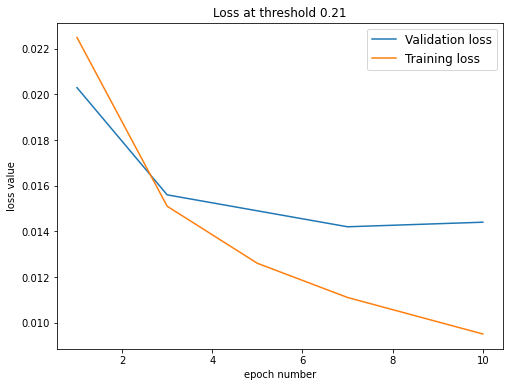

In [27]:
loss_021 = [0.0225, 0.0151, 0.0126, 0.0111, 0.0095]
val_021 = [0.0203, 0.0156, 0.0149, 0.0142, 0.0144]
x=[1, 3, 5, 7, 10]
plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(x, val_021, label="Validation loss")
plt.plot(x, loss_021, label="Training loss")
plt.title("Loss at threshold 0.21")
plt.xlabel("epoch number")
plt.ylabel("loss value")
plt.legend(loc="upper right", prop={'size': 12})

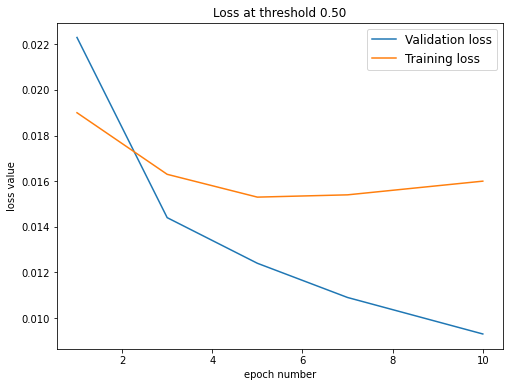

In [29]:
loss_05 = [0.0223, 0.0144, 0.0124, 0.0109, 0.0093]
val_05 = [0.0190, 0.0163, 0.0153, 0.0154, 0.0160]
x=[1, 3, 5, 7, 10]
plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(x, loss_05, label="Validation loss")
plt.plot(x, val_05, label="Training loss")
plt.title("Loss at threshold 0.50")
plt.xlabel("epoch number")
plt.ylabel("loss value")
plt.legend(loc="upper right", prop={'size': 12})